In [5]:
from numpy import random
from random import random as rand
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
np.random.seed(10)
from random import sample 
from IPython.display import clear_output

In [6]:
class GA():
    def __init__(self, data, pop_size=100, n_iterations = 50, mutation_prob = 0.1, crossover_prob = 0.2, memetic = False):

        
        self.pop_size = pop_size
        self.hist = []
        self.data = data
        self.ind_size = len(data)
        self.crossover_prob = crossover_prob
        self.n_iterations = n_iterations
        self.mutation_prob = mutation_prob
        self.memetic = memetic
        
        
    def generate_pop(self):
        self.pop =  np.array([random.permutation([i for i in range(0,self.ind_size)]) for x in range(self.pop_size) ])
        
    def tournament(self):
        new_pop = []
        for i in range(self.pop_size):
            
            indices = random.choice(len(self.pop), 2, replace=True)
            candidates = self.pop[indices]
            
            fittest =  candidates[0] if self.evaluate(candidates[0]) < self.evaluate(candidates[1]) else candidates[1]
            new_pop.append(fittest)
        return new_pop
    
    def evaluate(self,ind):
        l = []
        for i in range(self.ind_size-1):
            dist = np.linalg.norm(self.data[ind[i]]-self.data[ind[i+1]])    
            l.append(dist)
        return l, sum(l)
    
    def avg_pop(self, pop):
        return np.average([self.evaluate(x)[1] for x in pop])
    
    def get_best_sol(self, pop):
        best_index = 0
        best_fitness = self.evaluate(pop[0])[1]
        for i in range(1, len(pop)):
            current = self.evaluate(pop[0])[1]
            if (current > best_fitness):
                best_index = i
                best_fitness = current
        return (best_index, best_fitness)
    
    
    def order_crossover(self,p1, p2, p):
        if not (rand() < p):
            return p1, p2
        size = self.ind_size
        p1, p2 = list(p1), list(p2)
        #(1) CHOOSE 2 CUT POINTS
        start, end = np.sort(random.choice(range(1,size - 1), 2, replace = False))
        c1 = [-1] * size
        c2 = [-1] * size
        
        # (2) COPY BETWEEEN CUT POINTS TO OFFSPRINGS
        c1[start:end] = p1[start:end]
        c2[start:end] = p2[start:end]
        
        
        p1_order = p1[end:] + p1[:end]
        p2_order = p2[end:] + p2[:end]

        missing_indices = np.append(range(end,size),range(0,start))

        # (3) STARTING FROM 2ND CUT POINT IN ONE PARENT, FILL MISSING CITIES IN ORDER THEY APPEAR IN OTHER PARENT
        p1_pos, p2_pos = 0, 0
        for index in missing_indices:
            #child 1
            while True:
                if(p2_order[p2_pos] not in c1):
                    c1[index] = p2_order[p2_pos]
                    p2_pos += 1
                    break
                p2_pos += 1
            #child 2
            while True:
                if(p1_order[p1_pos] not in c2):
                    c2[index] = p1_order[p1_pos]
                    p1_pos += 1
                    break
                p1_pos += 1   
             
        return c1, c2
    
    def reverse_sequence_mutation(self, parent, p):
        result = parent.copy()
        if not (rand() < p):
            return parent
        size = self.ind_size
        i1, i2 = np.sort(random.choice(range(0,size ), 2, replace = False))
        old_parent = parent.copy()
        result[i1] = old_parent[i2]
        result[i2] = old_parent[i1]
        
        return result
    
    # 2-opt local search algorithm
    def opt2 (self, parent):
        existing_route = list(parent.copy())
        best_distance = self.evaluate(existing_route)[1]
        for i in range(len(parent)-3):
            for j in range(i+2, len(parent)-1):
                edge1 = [i, i+1]
                edge2 = [j, j+1]
                #reverse the part between the two edges
                rev = list(reversed(existing_route[edge1[1]:edge2[1]]))
                new_route = existing_route[:edge1[1]] + rev + existing_route[edge2[1]:] 
                new_distance = self.evaluate(new_route)[1]
                if(new_distance < best_distance): 
                    existing_route = new_route
                    best_distance = new_distance
        return existing_route
        
    
    def local_search (self, parents):
        new_parents = []
        for parent in parents:
            new_parents.append(self.opt2(parent))
        return new_parents
    
    def plotfunc(self, seq, locs, iteration, distance):
        sortlocs = [locs[_ind] for _ind in seq]
        xs = [loc[0] for loc in sortlocs]
        ys = [loc[1] for loc in sortlocs]
        
        algorithm_title = "Simple EA: " if not self.memetic else "Memetic algorithm: "

        plt.figure(0)
        plt.scatter(xs, ys)
        plt.plot(xs, ys)
        plt.title(f'{algorithm_title}Best solution with a total distance of {distance}')
        plt.show()
        
    def plot_results(self):
        clear_output(wait=True)
        best_fitness, best_solutions = [x[0] for x in self.hist], [x[1] for x in self.hist]
        best_solution = best_solutions[np.argmin(best_fitness)]
        print(f'best fitness: {np.min(best_fitness)}, found in epoch: {np.argmin(best_fitness)}')
        
        algorithm_title = "Simple EA: " if not self.memetic else "Memetic algorithm: "
        
        plt.plot(range(len(best_fitness)), [x for x in best_fitness])
        plt.title(f'{algorithm_title}plot of the evolution process')
        plt.xlabel('generation')
        plt.ylabel('Best fitness')
        plt.show()
        
        self.plotfunc(best_solution, self.data, np.argmin(best_fitness), np.min(best_fitness))
        
        
    def run(self):   
        
        self.generate_pop()
        
        #save the first generation
        best_index, best_fitness = self.get_best_sol(self.pop)
        self.hist.append((best_fitness, self.pop[best_index]))
        
         #LOCAL SEARCH
        if(self.memetic):
            self.pop = np.array(self.local_search(self.pop))


        for i in range(self.n_iterations):
            print(f'Processing generation {i+1}')
            #select parents for reproduction
            new_pop = self.tournament()
            
            for j in range(0, len(new_pop), 2):
                p1 = self.pop[j]
                p2 = self.pop[j+1]
                
                #recombine selected parents
                c1, c2 = self.order_crossover(p1,p2, self.crossover_prob)
                
                #mutate the resulting individuals
                c1 = self.reverse_sequence_mutation(c1, self.mutation_prob)
                c2 = self.reverse_sequence_mutation(c2, self.mutation_prob)

                new_pop[j] = c1
                new_pop[j+1] = c2
            
            #LOCAL SEARCH
            if(self.memetic):
                new_pop = self.local_search(new_pop)
            
            #save generation
            best_index, best_fitness = self.get_best_sol(self.pop)
            self.hist.append((best_fitness, self.pop[best_index]))
            
            self.pop = np.array(new_pop)
                

In [18]:
data = np.loadtxt('file-tsp.txt') 

best fitness: 444.6997221578599, found in epoch: 28


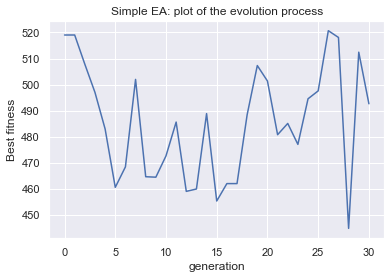

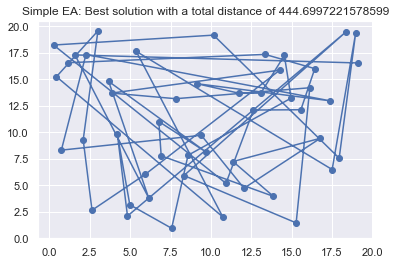

In [20]:
simple_EA = GA(data, n_iterations = 30, mutation_prob=0.8, pop_size=100, crossover_prob=0.8, memetic = False)
simple_EA.run()
simple_EA.plot_results()

best fitness: 123.24234080850964, found in epoch: 8


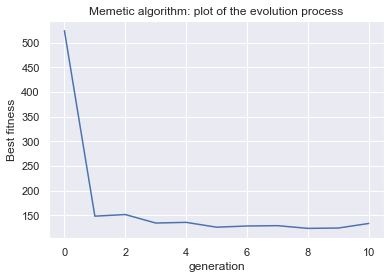

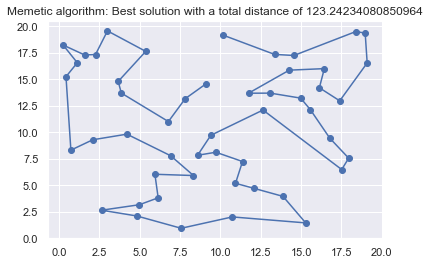

In [21]:
memetic_algorithm = GA(data,n_iterations = 10, mutation_prob=0.8, pop_size=100, crossover_prob=0.8, memetic = True)
memetic_algorithm.run()
memetic_algorithm.plot_results()

In [22]:
data = np.loadtxt('berlin52.tsp.txt')
#delete the useless first column
data = np.delete(data, 0, 1)

best fitness: 25832.81148587333, found in epoch: 5


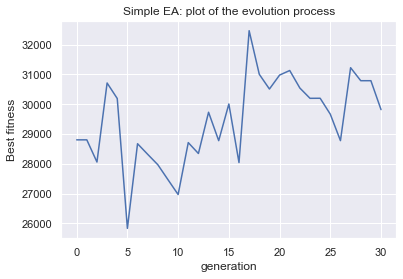

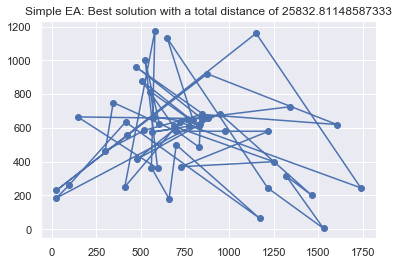

In [23]:
simple_EA = GA(data, n_iterations = 30, mutation_prob=0.8, pop_size=100, crossover_prob=0.8, memetic = False)
simple_EA.run()
simple_EA.plot_results()

best fitness: 8194.457155463402, found in epoch: 10


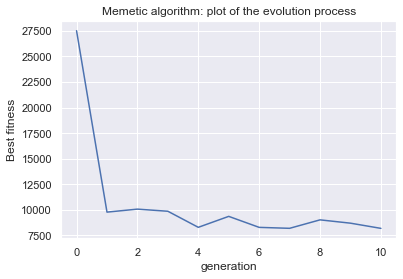

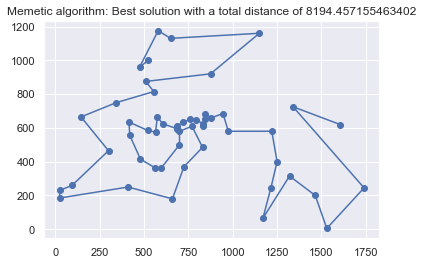

In [24]:
memetic_algorithm = GA(data, n_iterations = 10, mutation_prob=0.8, pop_size=100, crossover_prob=0.8, memetic = True)
memetic_algorithm.run()
memetic_algorithm.plot_results()